## Installing the wandb library and others

In [2]:
!pip install wandb onnx -Uq
!pip install datasets
# !pip install git+https://github.com/huggingface/transformers

## Ensuring deterministic behavior to improve reproducibility of results

In [3]:
import os
import random

import numpy as np
import torch
from tqdm.auto import tqdm

# Ensure deterministic behavior
torch.backends.cudnn.deterministic = True
random.seed(hash("setting random seeds") % 2**32 - 1)
np.random.seed(hash("improves reproducibility") % 2**32 - 1)
torch.manual_seed(hash("by removing stochasticity") % 2**32 - 1)
torch.cuda.manual_seed_all(hash("so runs are repeatable") % 2**32 - 1)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Logging into wandb

In [4]:
import wandb
kaggle = True

if kaggle:
  model_dir = '/kaggle/working'
  from kaggle_secrets import UserSecretsClient
  user_secrets = UserSecretsClient()
  secret_value_0 = user_secrets.get_secret("WANDB_API_KEY")

  wandb.login(key=secret_value_0)
else:
  from google.colab import drive
  drive.mount('/content/drive')
  model_dir = 'drive/MyDrive/ML/HuggingFace/models'
  wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: nasirsaeed-work (nasirsaeed-work-fast-nuces) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


## Functions to be used

In [5]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification, DataCollatorWithPadding
from datasets import load_dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import seaborn as sns
##########################################################################################

def get_roberta_model(num_labels=11, attention_probs_dropout_prob=0.1, classifier_dropout=0.0, hidden_dropout_prob=0.1):
    model = RobertaForSequenceClassification.from_pretrained(
        'roberta-base',
        num_labels=num_labels,
        attention_probs_dropout_prob=attention_probs_dropout_prob,
        classifier_dropout=classifier_dropout,
        hidden_dropout_prob=hidden_dropout_prob,
        architectures=["RobertaForSequenceClassificaton"]
    )
    return model


##########################################################################################
def get_roberta_dataloaders(dataset, BATCH_SIZE=16):
    tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
    # Tokenize dataset
    def tokenize_function(examples):
        return tokenizer(examples["text"], truncation=True)

    tokenized_dataset = dataset.map(tokenize_function, batched=True)

    # Remove unnecessary columns
    tokenized_dataset = tokenized_dataset.remove_columns(["text"])
    tokenized_dataset.set_format("torch")  # Convert to PyTorch tensors

    # Data collator dynamically pads sequences
    data_collator = DataCollatorWithPadding(tokenizer)

    train_dataloader = DataLoader(
        tokenized_dataset["train"], batch_size=BATCH_SIZE, shuffle=True, collate_fn=data_collator
    )

    valid_dataloader = DataLoader(
      tokenized_dataset["validation"], batch_size=BATCH_SIZE, shuffle=False, collate_fn=data_collator
    )

    test_dataloader = DataLoader(
      tokenized_dataset["test"], batch_size=BATCH_SIZE, shuffle=False, collate_fn=data_collator
    )

    return train_dataloader, valid_dataloader, test_dataloader

##########################################################################################

def get_metrics(model, dataloader, criterion, device):
    model.eval()

    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            inputs = batch['input_ids'].to(device)
            masks = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=inputs, attention_mask=masks)
            loss = criterion(outputs.logits, labels)
            total_loss += loss.item() * labels.size(0)

            preds = torch.argmax(outputs.logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(dataloader.dataset)
    acc = accuracy_score(all_labels, all_preds)

    return avg_loss, acc, all_preds, all_labels

##########################################################################################

def log_conf_matrix(preds, labels, class_names, split):
    cm = confusion_matrix(labels, preds)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'{split} Confusion Matrix')
    plt.show()

    wandb.log({f"{split}_confusion_matrix": wandb.Image(plt)})
    plt.close()



2025-04-16 07:00:37.055437: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744786837.336058      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744786837.411277      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## The make function

In [6]:
from datasets import load_dataset
from sklearn.utils.class_weight import compute_class_weight
from torch.optim.lr_scheduler import ReduceLROnPlateau

def make(config, device):
    # Make the data
    dataset = load_dataset(
        'csv',
        data_files={
            'train': '/kaggle/input/bank-nlu-classification/train.csv',
            'validation': '/kaggle/input/bank-nlu-classification/valid.csv',
            'test': '/kaggle/input/bank-nlu-classification/test.csv',
        }
    )

    dataset = dataset.rename_column('category', 'label')
    train_dataloader, valid_dataloader, test_dataloader = get_roberta_dataloaders(dataset, BATCH_SIZE=config.batch_size)

    # Make the model
    model = get_roberta_model(num_labels=config.num_labels, attention_probs_dropout_prob=config.attention_probs_dropout_prob, classifier_dropout=config.classifier_dropout, hidden_dropout_prob=config.hidden_dropout_prob).to(device)

    #initialzing class weights
    y_train = dataset["train"]["label"]
    class_weights = compute_class_weight("balanced", classes=np.unique(y_train), y=np.array(y_train))
    class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

    #creating loss function
    if config.weighted_loss:
      criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
    else:
      criterion = torch.nn.CrossEntropyLoss()

    # creating optimizer
    optimizer = torch.optim.Adam(
        model.parameters(), lr=config.lr, weight_decay=config.weight_decay)

    #creating schedular
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=config.schedular_factor, patience=config.schedular_patience)

    return model, train_dataloader, valid_dataloader, test_dataloader, criterion, optimizer, scheduler

In [7]:
import torch
import wandb
import os
import numpy as np
from sklearn.metrics import accuracy_score
from tqdm import tqdm

def train_batch(batch, model, optimizer, criterion, device):
    model.train()
    inputs = batch['input_ids'].to(device)
    masks = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device)

    optimizer.zero_grad()
    outputs = model(input_ids=inputs, attention_mask=masks)
    loss = criterion(outputs.logits, labels)
    loss.backward()
    optimizer.step()

    return loss.item()


def train(model, train_loader, val_loader, criterion, optimizer, config, device, scheduler):
    wandb.watch(model, criterion, log="all", log_freq=10)

    os.makedirs(config.model_dir, exist_ok=True)

    example_ct = 0
    batch_ct = 0

    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(config.epochs):
        model.train()
        running_loss = 0

        batch_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{config.epochs}", leave=False)

        for batch in batch_bar:
            loss = train_batch(batch, model, optimizer, criterion, device)
            running_loss += loss
            example_ct += len(batch['input_ids'])
            batch_ct += 1

            batch_bar.set_postfix({"Batch Loss": f"{loss:.4f}"})

            if ((batch_ct + 1) % config.log_interval) == 0:
                wandb.log({"train/loss": loss, "epoch": epoch + 1}, step=example_ct)

                if config.log_val_batches:
                    val_loss, val_acc, _, _ = get_metrics(model, val_loader, criterion, device)
                    wandb.log({"val/loss": val_loss, "val/accuracy": val_acc, "epoch": epoch + 1}, step=example_ct)

        # End of epoch
        val_loss, val_acc, _, _ = get_metrics(model, val_loader, criterion, device)
        avg_train_loss = running_loss / len(train_loader)

        wandb.log({
            "train/epoch_loss": avg_train_loss,
            "val/epoch_loss": val_loss,
            "val/accuracy": val_acc,
            "epoch": epoch + 1
        }, step=example_ct)

        print(f"\nEpoch {epoch + 1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {val_loss:.4f}, Val Acc = {val_acc:.4f}")

        # Scheduler step
        if scheduler.__class__.__name__ == "ReduceLROnPlateau":
            scheduler.step(val_loss)
        else:
            scheduler.step()

        current_lr = optimizer.param_groups[0]['lr']
        print(f"Current Learning Rate: {current_lr:.8f}")

        # Check for improvement
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0

            # Save best model
            best_model_path = os.path.join(config.model_dir, "best_model.pth")
            torch.save(model.state_dict(), best_model_path)

            # WandB artifact
            artifact = wandb.Artifact(f"best-model-epoch{epoch+1}", type='model')
            artifact.add_file(best_model_path)
            wandb.log_artifact(artifact)
        else:
            patience_counter += 1
            if patience_counter >= config.early_stopping_patience:
                print(f"\nEarly stopping triggered at epoch {epoch + 1}")
                break

    # Save last epoch model
    last_model_path = os.path.join(config.model_dir, "last_model.pth")
    torch.save(model.state_dict(), last_model_path)

    # ---- Validation + Train Confusion Matrices ----
    if config.log_confusion_matrix:
        train_loss, train_acc, train_preds, train_labels = get_metrics(model, train_loader, criterion, device)
        log_conf_matrix(train_preds, train_labels, config.class_names, split="train")

        val_loss, val_acc, val_preds, val_labels = get_metrics(model, val_loader, criterion, device)
        log_conf_matrix(val_preds, val_labels, config.class_names, split="val")

    print(f"\nTraining complete. Best model saved at: {best_model_path}\nLast model saved at: {last_model_path}")

    

## Function to test performance

In [8]:
def test(model, test_loader, criterion, device, config):
    avg_loss, accuracy, all_preds, all_labels = get_metrics(model, test_loader, criterion, device)

    print(f"\n📄 Test Results --> Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

    wandb.log({
        "test/loss": avg_loss,
        "test/accuracy": accuracy
    })

    log_conf_matrix(all_preds, all_labels, config.class_names, split="test")
    
    return avg_loss, accuracy


## Defining model pipeline

In [9]:
def model_pipeline(hyperparameters):

    # tell wandb to get started
    with wandb.init(project="Bank_Task_Classifier", config=hyperparameters):
      # access all HPs through wandb.config, so logging matches execution!
      wandb_config = wandb.config

      device = "cuda" if torch.cuda.is_available() else "cpu"
        
      # make the model, data, and optimization problem
      model, train_loader, valid_loader, test_loader, criterion, optimizer, schedular = make(wandb_config, device)
      print(model)

      # and use them to train the model
      train(model, train_loader, valid_loader, criterion, optimizer, wandb_config, device, schedular)

      # and test its final performance
      test(model, test_loader, criterion, device, wandb_config)

    return model

## Defining meta data (hyperparameters and model architecture etc)

In [10]:
config = dict(epochs=2,
              lr=5e-6,
              weight_decay=0.0,
              attention_probs_dropout_prob=0.1, 
              classifier_dropout=0.0,
              hidden_dropout_prob=0.1,
              batch_size=16,
              weighted_loss=True,
              architecture='RobertaForSequenceClassification',
              num_labels=11,
              schedular_patience=1,
              schedular_factor=0.1,
              early_stopping_patience=4,
              log_val_batches=True,
              log_interval=25,
              model_dir=model_dir,
              log_confusion_matrix=True,
              class_names=['account_settings', 'platform_support', 'security', 'card_management', 'cash_withdrawal_issues', 'refunds', 'identity_compliance', 'transfers', 'top_up', 'currency_exchange', 'card_usage_issues']
             )

## Creating model with parameters

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Map:   0%|          | 0/8002 [00:00<?, ? examples/s]

Map:   0%|          | 0/2001 [00:00<?, ? examples/s]

Map:   0%|          | 0/3080 [00:00<?, ? examples/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         


Epoch 1: Train Loss = 1.1805, Val Loss = 0.3038, Val Acc = 0.9100
Current Learning Rate: 0.00000500



Epoch 2: Train Loss = 0.2814, Val Loss = 0.2098, Val Acc = 0.9340
Current Learning Rate: 0.00000500


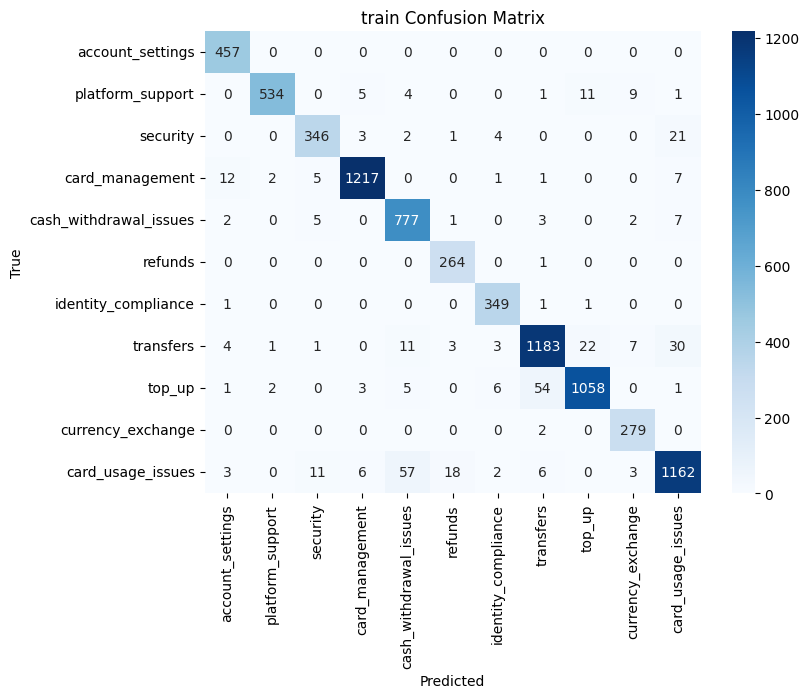

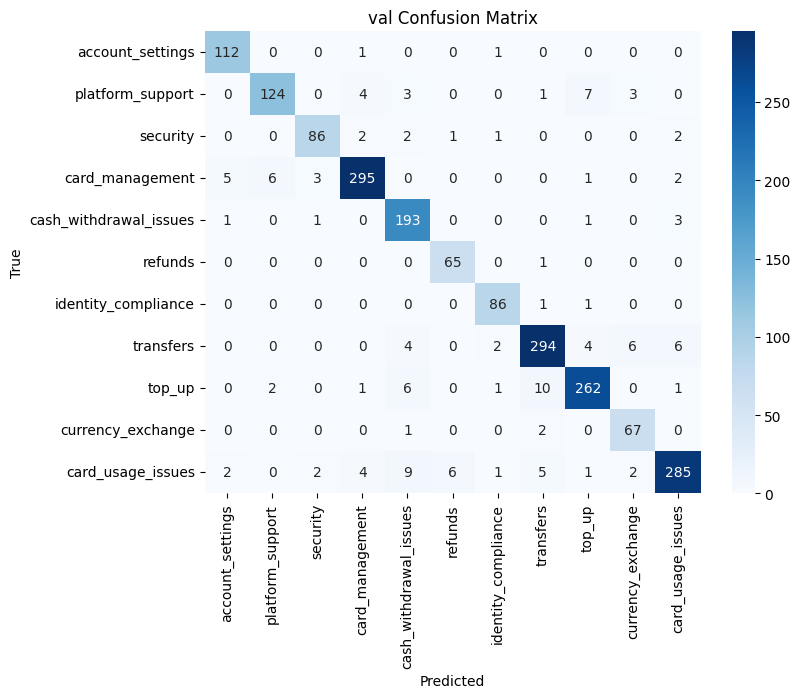


Training complete. Best model saved at: /kaggle/working/best_model.pth
Last model saved at: /kaggle/working/last_model.pth

📄 Test Results --> Loss: 0.2540, Accuracy: 0.9276


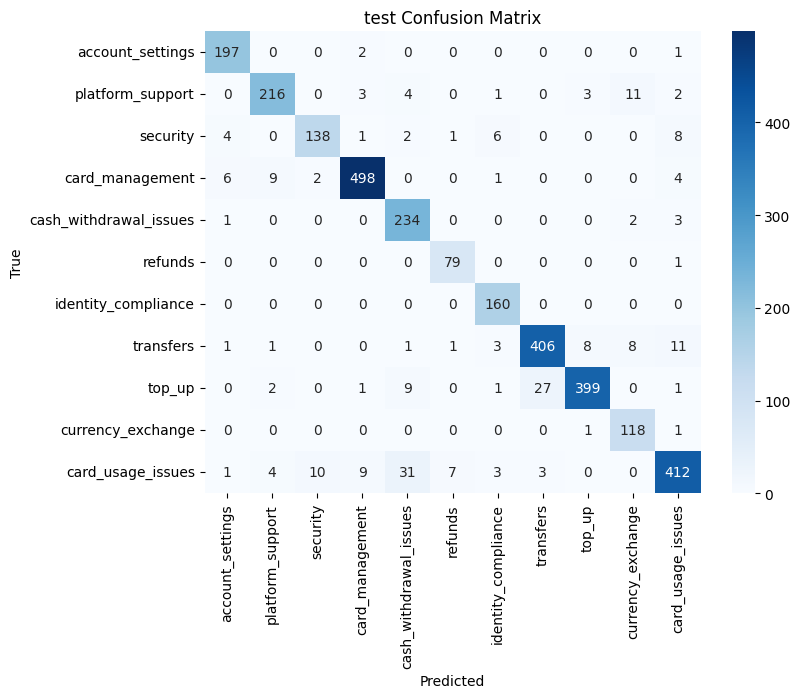

epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁████████████████████
test/accuracy,▁
test/loss,▁
train/epoch_loss,█▁
train/loss,████▆▆▅▅▄▃▃▃▂▃▂▂▂▁▂▁▁▂▂▁▂▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁
val/accuracy,▁▁▂▄▅▆▇▇▇▇▇▇▇███████████████████████████
val/epoch_loss,█▁
val/loss,████▆▅▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,2
test/accuracy,0.9276
test/loss,0.25404


In [11]:
# Build, train and analyze the model with the pipeline
model = model_pipeline(config)